In [17]:

import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
import librosa
import librosa.display
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
import shutil
from zipfile import ZipFile
import shutil 
import gdown
import joblib

gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

In [18]:
# Update: Original Dataset source seems to have been taken down

# Please download the GTZAN Dataset from Kaggle:
# https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification?resource=download

# Drag the zip file into the root of this project! The notebook will handle the rest.

In [19]:
rootDir = ".."

In [20]:
# Unzip the dataset ZIP and format directory
if "datasets" not in os.listdir(".."):
    for file in os.listdir(".."):
        if file.endswith(".zip"):
            d0 = os.path.join(rootDir, file)
            with ZipFile(d0, 'r') as zObject:
                zObject.extractall(path="..")

            if "datasets" not in os.listdir(".."):
                for f in os.listdir(f"{rootDir}/Data/"):
                    if f == "genres_original":
                        d1 = os.path.join(f"{rootDir}/Data", f)
                        newPath =  os.path.join(f"{rootDir}/Data/","datasets")
                        os.rename(d1,newPath)
                        shutil.move(newPath, "..") 
                        os.mkdir("../datasets/genres30sec")
                        for wavDir in os.listdir("../datasets"):
                            d2 = os.path.join("../datasets", wavDir)
                            if wavDir != "genres30sec":
                                shutil.move(d2, "../datasets/genres30sec") 
                                      
                shutil.rmtree("../Data")
                # os.remove(f"../{d0}")
                
                # jazz.00054.wav is corrupted. We replace the file with the new one at this link:
                # https://drive.google.com/file/d/14ZV9Wf-6pr32PIRT_ziuvFvh9tQsHpQ4/view
                
                url = "https://drive.google.com/u/0/uc?id=14ZV9Wf-6pr32PIRT_ziuvFvh9tQsHpQ4&export=download"
                output = '../datasets/genres30sec/jazz/jazz.00054.wav'
                gdown.download(url, output, quiet=False)


In [21]:
# Set to appropriate path if this file is moved
dataDir = f"{rootDir}/datasets"

In [22]:
# Split 30 sec audio to 3 sec

genres = 'blues classical country disco hiphop jazz metal pop reggae rock'
genres = genres.split()

if not os.path.exists(f'{dataDir}/genres3sec'):
  os.makedirs(f'{dataDir}/genres3sec')

  if len(os.listdir(os.path.join(f'{dataDir}/genres3sec'))) == 0:
    for g in genres:
      path_audio = os.path.join(f'{dataDir}/genres3sec',f'{g}')
      os.makedirs(path_audio)
    
  from pydub import AudioSegment
  i = 0
  for g in genres:
    #if len(os.listdir(os.path.join(f'{dataDir}/audio3sec/',f"{g}"))) == 0:
      j=0
      print(f"{g}")
      for filename in os.listdir(os.path.join(f'{dataDir}/genres30sec',f"{g}")):
        song  =  os.path.join(f'{dataDir}/genres30sec/{g}',f'{filename}')
        j = j+1
        for w in range(0,10):
          i = i+1
          #print(i)
          t1 = 3*(w)*1000
          t2 = 3*(w+1)*1000
          newAudio = AudioSegment.from_wav(song)
          new = newAudio[t1:t2]
          new.export(f'{dataDir}/genres3sec/{g}/{g+str(j)+str(w)}.wav', format="wav")

In [23]:
# Load Example frile for Example of MFCC & MelSpectrogram
y,sr = librosa.load(f'{dataDir}/genres3sec/blues/blues10.wav',duration=3)


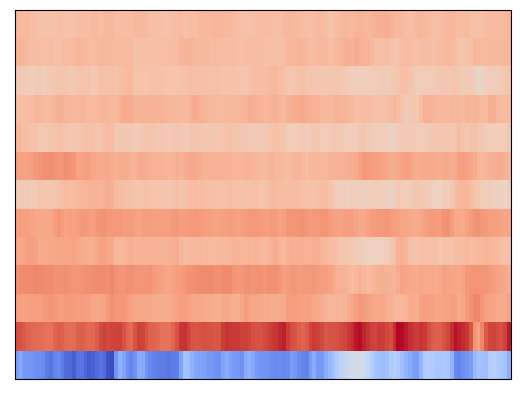

In [24]:
# MFCC
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc= 13, hop_length=512, n_fft=2048)
fig = plt.Figure(figsize=(13, 130))
canvas = FigureCanvas(fig)
p = librosa.display.specshow(mfccs)

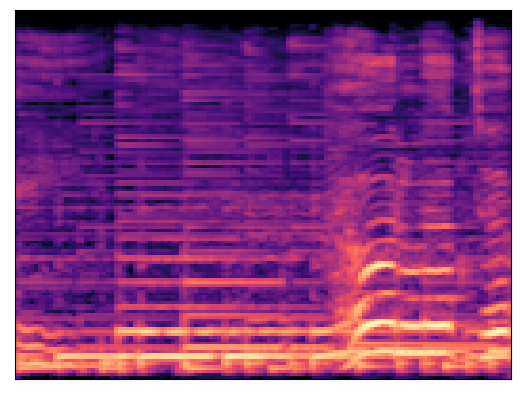

In [25]:
# MelSpectrogram
mels = librosa.feature.melspectrogram(y=y,sr=sr)
fig = plt.Figure(figsize=(13, 130))
canvas = FigureCanvas(fig)
p = librosa.display.specshow(librosa.power_to_db(mels, ref=np.max))

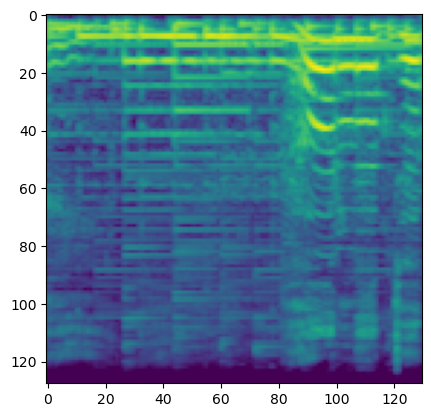

In [26]:
# MelSpectrogram (Alt)
mels = librosa.feature.melspectrogram(y=y,sr=sr)
fig = plt.Figure()
canvas = FigureCanvas(fig)
p = plt.imshow(librosa.power_to_db(mels,ref=np.max))

In [27]:
# MFCCs for 3 Sec Clips

genres = 'blues classical country disco hiphop jazz metal pop reggae rock'
genres = genres.split()

  
if not os.path.exists(f'{dataDir}/mfccs3sec'):
    os.makedirs(f'{dataDir}/mfccs3sec')
    os.makedirs(f'{dataDir}/mfccs3sec/train')
    os.makedirs(f'{dataDir}/mfccs3sec/test')

    for g in genres:
        path_train = os.path.join(f'{dataDir}/mfccs3sec/train',f'{g}')
        path_test = os.path.join(f'{dataDir}/mfccs3sec/test',f'{g}')
        os.makedirs(path_train)
        os.makedirs(path_test)


    # # Multi-Core Implmentation (Batches) [Fastest]
    def task(dd, g,j,filename):
        song  =  os.path.join(f'{dd}/genres3sec/{g}',f'{filename}')
        y,sr = librosa.load(song,duration=3)
        #############################################################################
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc= 13, hop_length=512, n_fft=2048)
        fig = plt.Figure(figsize=(13, 130))
        canvas = FigureCanvas(fig)
        p = librosa.display.specshow(mfccs)
        #########################################################
        plt.savefig(f'{dd}/mfccs3sec/train/{g}/{g+str(j)}.png')
        plt.close()


    batch_size=128
    for g in genres:
        print(g)
        
        wavFiles = os.listdir(os.path.join(f'{dataDir}/genres3sec',f"{g}"))
        processes = [ joblib.delayed(task)(dataDir,g,itr,wavFiles[itr]) for itr in range(len(wavFiles))  ]
        _ = joblib.Parallel(n_jobs=batch_size)(processes)

In [28]:
# MFCCs for 30 Sec Clips

genres = 'blues classical country disco hiphop jazz metal pop reggae rock'
genres = genres.split()

  
if not os.path.exists(f'{dataDir}/mfccs30sec'):
  os.makedirs(f'{dataDir}/mfccs30sec')
  os.makedirs(f'{dataDir}/mfccs30sec/train')
  os.makedirs(f'{dataDir}/mfccs30sec/test')

  for g in genres:
    path_train = os.path.join(f'{dataDir}/mfccs30sec/train',f'{g}')
    path_test = os.path.join(f'{dataDir}/mfccs30sec/test',f'{g}')
    os.makedirs(path_train)
    os.makedirs(path_test)

  # Multi-Core Implmentation (Batches) Fastest
  def task(dd,g,j,filename):
      song  =  os.path.join(f'{dd}/genres30sec/{g}',f'{filename}')
      y,sr = librosa.load(song,duration=3)
      #############################################################################
      mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc= 13, hop_length=512, n_fft=2048)
      fig = plt.Figure(figsize=(13, 130))
      canvas = FigureCanvas(fig)
      p = librosa.display.specshow(mfccs)
      #########################################################
      plt.savefig(f'{dd}/mfccs30sec/train/{g}/{g+str(j)}.png')
      plt.close()

  batch_size=128
  for g in genres:
      print(g)
      
      wavFiles = os.listdir(os.path.join(f'{dataDir}/genres30sec',f"{g}"))
      processes = [ joblib.delayed(task)(dataDir,g,itr,wavFiles[itr]) for itr in range(len(wavFiles))  ]
      _ = joblib.Parallel(n_jobs=batch_size)(processes)

In [29]:
# Mel Spectrogram for 3 Sec Clips

genres = 'blues classical country disco hiphop jazz metal pop reggae rock'
genres = genres.split()

  
if not os.path.exists(f'{dataDir}/spectrograms3sec'):
    os.makedirs(f'{dataDir}/spectrograms3sec')
    os.makedirs(f'{dataDir}/spectrograms3sec/train')
    os.makedirs(f'{dataDir}/spectrograms3sec/test')

    for g in genres:
        path_train = os.path.join(f'{dataDir}/spectrograms3sec/train',f'{g}')
        path_test = os.path.join(f'{dataDir}/spectrograms3sec/test',f'{g}')
        os.makedirs(path_train)
        os.makedirs(path_test)

    # Parallel (Batches) [Fastest]
    def task(dd,g,j,filename):
        song  =  os.path.join(f'{dd}/genres3sec/{g}',f'{filename}')
        y,sr = librosa.load(song,duration=3)
        #############################################################################
        mels = librosa.feature.melspectrogram(y=y,sr=sr)
        fig = plt.Figure(figsize=(13, 130))
        canvas = FigureCanvas(fig)
        p = librosa.display.specshow(librosa.power_to_db(mels, ref=np.max))
        #########################################################
        plt.savefig(f'{dd}/spectrograms3sec/train/{g}/{g+str(j)}.png')
        plt.close()

    batch_size=128
    for g in genres:
        print(g)
        
        wavFiles = os.listdir(os.path.join(f'{dataDir}/genres3sec',f"{g}"))
        processes = [ joblib.delayed(task)(dataDir,g,itr,wavFiles[itr]) for itr in range(len(wavFiles))  ]
        _ = joblib.Parallel(n_jobs=batch_size)(processes)

In [30]:
# Mel Spectrogram for 30 Sec Clips

genres = 'blues classical country disco hiphop jazz metal pop reggae rock'
genres = genres.split()


if not os.path.exists(f'{dataDir}/spectrograms30sec'):
    os.makedirs(f'{dataDir}/spectrograms30sec')
    os.makedirs(f'{dataDir}/spectrograms30sec/train')
    os.makedirs(f'{dataDir}/spectrograms30sec/test')

    for g in genres:
        path_train = os.path.join(f'{dataDir}/spectrograms30sec/train',f'{g}')
        path_test = os.path.join(f'{dataDir}/spectrograms30sec/test',f'{g}')
        os.makedirs(path_train)
        os.makedirs(path_test)

    # Multi-Core Implmentation (Batches) [Fastest]
    def task(dd,g,j,filename):
        song  =  os.path.join(f'{dd}/genres30sec/{g}',f'{filename}')
        y,sr = librosa.load(song,duration=3)
        #############################################################################
        mels = librosa.feature.melspectrogram(y=y,sr=sr)
        fig = plt.Figure(figsize=(13, 130))
        canvas = FigureCanvas(fig)
        p = librosa.display.specshow(librosa.power_to_db(mels, ref=np.max))
        #########################################################
        plt.savefig(f'{dd}/spectrograms30sec/train/{g}/{g+str(j)}.png')
        plt.close()
        
    batch_size=128
    for g in genres:
        print(g)
        
        wavFiles = os.listdir(os.path.join(f'{dataDir}/genres30sec',f"{g}"))
        processes = [ joblib.delayed(task)(dataDir,g,itr,wavFiles[itr]) for itr in range(len(wavFiles))  ]
        _ = joblib.Parallel(n_jobs=batch_size)(processes)

In [31]:
# Mel Spectrogram Alt for 3 Sec Clips

genres = 'blues classical country disco hiphop jazz metal pop reggae rock'
genres = genres.split()

  
if not os.path.exists(f'{dataDir}/spectrogramsAlt3sec'):
    os.makedirs(f'{dataDir}/spectrogramsAlt3sec')
    os.makedirs(f'{dataDir}/spectrogramsAlt3sec/train')
    os.makedirs(f'{dataDir}/spectrogramsAlt3sec/test')

    for g in genres:
        path_train = os.path.join(f'{dataDir}/spectrogramsAlt3sec/train',f'{g}')
        path_test = os.path.join(f'{dataDir}/spectrogramsAlt3sec/test',f'{g}')
        os.makedirs(path_train)
        os.makedirs(path_test)

    # Parallel (Batches) [Fastest]
    def task(dd,g,j,filename):
        song  =  os.path.join(f'{dd}/genres3sec/{g}',f'{filename}')
        y,sr = librosa.load(song,duration=3)
        #############################################################################
        mels = librosa.feature.melspectrogram(y=y,sr=sr)
        fig = plt.Figure()
        canvas = FigureCanvas(fig)
        p = plt.imshow(librosa.power_to_db(mels,ref=np.max))
        #########################################################
        plt.savefig(f'{dd}/spectrogramsAlt3sec/train/{g}/{g+str(j)}.png')
        plt.close()

    batch_size=128
    for g in genres:
        print(g)
        
        wavFiles = os.listdir(os.path.join(f'{dataDir}/genres3sec',f"{g}"))
        processes = [ joblib.delayed(task)(dataDir,g,itr,wavFiles[itr]) for itr in range(len(wavFiles))  ]
        _ = joblib.Parallel(n_jobs=batch_size)(processes)

blues
classical
country
disco
hiphop
jazz
metal
pop
reggae
rock


In [ ]:
# Mel Spectrogram Alt for 30 Sec Clips

genres = 'blues classical country disco hiphop jazz metal pop reggae rock'
genres = genres.split()


if not os.path.exists(f'{dataDir}/spectrogramsAlt30sec'):
    os.makedirs(f'{dataDir}/spectrogramsAlt30sec')
    os.makedirs(f'{dataDir}/spectrogramsAlt30sec/train')
    os.makedirs(f'{dataDir}/spectrogramsAlt30sec/test')

    for g in genres:
        path_train = os.path.join(f'{dataDir}/spectrogramsAlt30sec/train',f'{g}')
        path_test = os.path.join(f'{dataDir}/spectrogramsAlt30sec/test',f'{g}')
        os.makedirs(path_train)
        os.makedirs(path_test)

    # Multi-Core Implmentation (Batches) [Fastest]
    def task(dd,g,j,filename):
        song  =  os.path.join(f'{dd}/genres30sec/{g}',f'{filename}')
        y,sr = librosa.load(song,duration=3)
        #############################################################################
        mels = librosa.feature.melspectrogram(y=y,sr=sr)
        fig = plt.Figure()
        canvas = FigureCanvas(fig)
        p = plt.imshow(librosa.power_to_db(mels,ref=np.max))
        #########################################################
        plt.savefig(f'{dd}/spectrogramsAlt30sec/train/{g}/{g+str(j)}.png')
        plt.close()
        
    batch_size=128
    for g in genres:
        print(g)
        
        wavFiles = os.listdir(os.path.join(f'{dataDir}/genres30sec',f"{g}"))
        processes = [ joblib.delayed(task)(dataDir,g,itr,wavFiles[itr]) for itr in range(len(wavFiles))  ]
        _ = joblib.Parallel(n_jobs=batch_size)(processes)